# Importovanie kniznic

In [1]:
# !pip install numpy==1.26.3
!pip install matplotlib cartopy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import json

from datetime import datetime, time

In [2]:
import pandas as pd

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
# Polohy vysielacov a prijimaca
RECEIVER = {"latitude": 44.85540, "longitude": 20.39108}
TRANSMITTERS = [
    {"latitude": 40.922889, "longitude": 9.732052, "frequency": 20.27, "name": "ICV"},
    {"latitude": 66.982337, "longitude": 13.872471, "frequency": 16.4, "name": "JXN"},
    {"latitude": 53.087341, "longitude": 7.608652, "frequency": 23.4, "name": "DHO"},
    {"latitude": 54.731929, "longitude": 2.883359, "frequency": 22.1, "name": "GVT"},
]

NUMBER_OF_BINS = 9
ATTENUATION = 0.8
ATTENUATION_DISTANCE = 250 # km

# Vypocet vzdialenosti medzi vysielacom a prijimacom

In [4]:
# Haversinova formula na vypocet vzialenosti 2 bodov na mape pomocou zem. sirky a vysky
def haversine(lat1, lon1, lat2, lon2):
    # Polomer Zeme v kilometroch
    R = 6371.0  
    
    # Konverzia stupnov na radiany
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Rozdiely suradnic
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    # Haversineova formula
    a = math.sin(delta_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    
    return int(distance)

# vypocet kolmej vzdialenosti medzi zemetrasenim a spojenim vysielac-prijimac
def shortest_distance(lat1, lon1, lat2, lon2, lat_p, lon_p):   
    AP = haversine(lat1, lon1, lat_p, lon_p)
    BP = haversine(lat2, lon2, lat_p, lon_p)
    
    # Projekcia na úsečku
    lat1, lon1, lat2, lon2, lat_p, lon_p = map(math.radians, [lat1, lon1, lat2, lon2, lat_p, lon_p])
    a = math.sin(lat2 - lat1) * math.sin(lat_p - lat1) + math.cos(lat1) * math.cos(lat_p) * math.sin(lon2 - lon1) * math.sin(lon_p - lon1)
    b = math.sin(lat2 - lat1) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(lon2 - lon1) ** 2
    t = a / b

    if t < 0: 
        return AP
    elif t > 1: 
        return BP
    else: 
        Px_lat = math.degrees(lat1 + t * (lat2 - lat1))
        Px_lon = math.degrees(lon1 + t * (lon2 - lon1))
        return haversine(math.degrees(lat_p), math.degrees(lon_p), Px_lat, Px_lon)

In [5]:
# vypocet vzdialenosti medzi kazdym vysielacom a prijimacom
for trans in TRANSMITTERS:
    trans["distance"] =  haversine(trans.get("latitude"), trans.get("longitude"), RECEIVER.get("latitude"), RECEIVER.get("longitude"))

In [6]:
TRANSMITTERS

[{'latitude': 40.922889,
  'longitude': 9.732052,
  'frequency': 20.27,
  'name': 'ICV',
  'distance': 971},
 {'latitude': 66.982337,
  'longitude': 13.872471,
  'frequency': 16.4,
  'name': 'JXN',
  'distance': 2490},
 {'latitude': 53.087341,
  'longitude': 7.608652,
  'frequency': 23.4,
  'name': 'DHO',
  'distance': 1303},
 {'latitude': 54.731929,
  'longitude': 2.883359,
  'frequency': 22.1,
  'name': 'GVT',
  'distance': 1660}]

/tmp/ipykernel_822/1071723276.py:30: UserWarning: Mismatched number of handles and labels: len(handles) = 1 len(labels) = 3
  ax.legend(loc="upper left", handles=lines[:2] + lines[10:11], labels=["Belehrad", "Vysielač", "Bod"])
/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


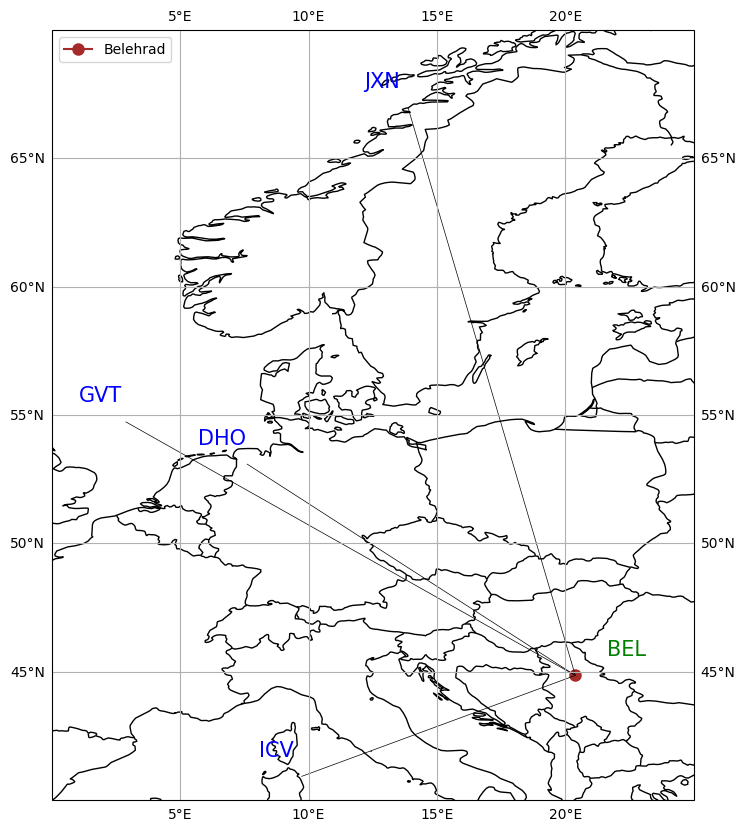

In [9]:
# zobrazenie vysielacov a prijimaca a vzdialenost medzi nimi

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([0, 25, 40, 70])

# Pridanie geografických prvkov
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='solid')

# vykreslenie prijimaca
ax.plot(RECEIVER.get("longitude"), RECEIVER.get("latitude"), marker='o', color='brown', markersize=8, label='Belehrad')
ax.text(RECEIVER.get("longitude") + 2, RECEIVER.get("latitude") + 0.8, "BEL", color='green', fontsize=15, ha='center')

# vykreslenie vysielacov
for trans in TRANSMITTERS:
    lat = trans.get("latitude")
    lon = trans.get("longitude")
    name = trans.get("name")
    # Vykreslenie úsečky
    ax.plot([RECEIVER.get("longitude"), lon],
            [RECEIVER.get("latitude"), lat],
            color="black",
            linewidth=0.5,
           )
    ax.text(lon - 1, lat + 0.8, name, color='blue', fontsize=15, ha='center')

lines, line_names = ax.get_legend_handles_labels()
ax.legend(loc="upper left", handles=lines[:2] + lines[10:11], labels=["Belehrad", "Vysielač", "Bod"])
ax.gridlines(draw_labels=True)

plt.show()

# Vypocet kolmej vzdialenosti medzi zemetrasenia od vzdialenosti medzi vysielacom a prijimacom

In [7]:
# nacitanie zemetraseni
eq_df = pd.read_csv("earthquakes.csv")
eq_df.drop(columns=[col for col in eq_df.columns if col.startswith("Unnamed")], inplace=True)
print(len(eq_df))
eq_df.head(1)

3172


,date,time,latitude,longitude,region name,depth,magnitude type,magnitude,eqid,hour,minute,second,datetime
0,2016-11-16,23:26:22,35.05,23.15,"CRETE, GREECE",16,ML,2.4,550922,23,26,22.0,2016-11-16 23:26:22


In [8]:
eq_df["region name"].value_counts()

CENTRAL ITALY                       1457
WESTERN TURKEY                       447
GREECE                               411
SOUTHERN GREECE                       86
CRETE, GREECE                         82
DODECANESE ISLANDS, GREECE            74
DODECANESE IS.-TURKEY BORDER REG      66
NEAR THE COAST OF WESTERN TURKEY      64
AEGEAN SEA                            49
SWITZERLAND                           41
FRANCE                                36
ALBANIA                               30
ROMANIA                               25
GERMANY                               25
IONIAN SEA                            24
CENTRAL MEDITERRANEAN SEA             20
EASTERN MEDITERRANEAN SEA             17
SVALBARD REGION                       16
SICILY, ITALY                         15
NORTHERN ITALY                        15
NORTHERN ALGERIA                      12
POLAND                                12
PYRENEES                              12
SOUTHERN ITALY                        12
STRAIT OF GIBRAL

In [10]:
# najdenie najvacsieho zemetrasenia v danej hodine dna 

points_attenuated_magnitudes_per_day = []

biggest_eq_inf_on_path_list = []
eq_inf_on_path_list = []

# prechadzam kazdy den
for date, _ in eq_df.groupby(["date"]):
    eqs = eq_df.loc[eq_df["date"] == date]
    # prechadzam hodiny v dni, kedy sa vyskytlo zemetrasenie
    for hour, _ in eqs.groupby(["hour"]):
        hour_window_eqs = eqs.loc[eqs["hour"] == hour]
        # prechadzam kazdy vysielac
        for trans in TRANSMITTERS:
            trans_name = trans.get("name")
            biggest_eq_inf_on_path_per_hour = {
                "eqid": 0,
                "magnitude": 0
            }
            # prechadzam zemetrasenia pre danu hodinu
            for _, eq in hour_window_eqs.iterrows():
                eq_dist_from_path = shortest_distance(
                    trans.get("latitude"), trans.get("longitude"), RECEIVER.get("latitude"), RECEIVER.get("longitude"), eq.get("latitude"), eq.get("longitude")
                )
                # beriem iba zemetrasenie, ktorych vzdialenost je kratsia ako 250 km
                if eq_dist_from_path < 250:
                    eq["has_influence_on"] = trans_name
                    eq["dist_from_path"] = eq_dist_from_path
                    eq_inf_on_path_list.append(eq)
                    # beriem iba zemetrasenie, ktorych vzdialenost je kratsia ako 250 km a su najsilnejsie v danej hodine
                    if eq.get("magnitude") > biggest_eq_inf_on_path_per_hour.get("magnitude"):
                        biggest_eq_inf_on_path_per_hour["eqid"] = eq.get("eqid")
                        biggest_eq_inf_on_path_per_hour["magnitude"] = eq.get("magnitude")
                        biggest_eq_inf_on_path_per_hour[f"has_influence_on"] = trans_name

            if biggest_eq_inf_on_path_per_hour.get("eqid") != 0:
                biggest_eq_inf_on_path_list.append(biggest_eq_inf_on_path_per_hour) 
                

In [11]:
# vyber zemetraseni s magnitudou vacsou ako 2
df = pd.DataFrame(eq_inf_on_path_list)
df_droped = df.loc[df["magnitude"] >= 2.0 ]

biggest_eq_inf_on_path_df = pd.DataFrame(biggest_eq_inf_on_path_list)
df_eq = eq_df.merge(biggest_eq_inf_on_path_df, how="inner", on="eqid")

df_eq.drop(columns=[col for col in df_eq.columns if col.endswith("_y")], inplace=True)
df_eq.rename(columns={"magnitude_x": "magnitude"}, inplace=True)
df_eq = df_eq.loc[df_eq["magnitude"] >= 2.0]
df_eq.head(1)

,date,time,latitude,longitude,region name,depth,magnitude type,magnitude,eqid,hour,minute,second,datetime,has_influence_on
0,2016-11-16,22:55:54,42.83,13.11,CENTRAL ITALY,10,ML,2.5,546052,22,55,54.0,2016-11-16 22:55:54,ICV


In [12]:
len(df_droped)

1556

In [13]:
len(df_eq)

546

In [54]:
# ulozenie datasetov
# df_eq.to_csv("eq_biggest_influence_per_hour.csv")
# df_droped.to_csv("eq_influence_on_path.csv")

546
502


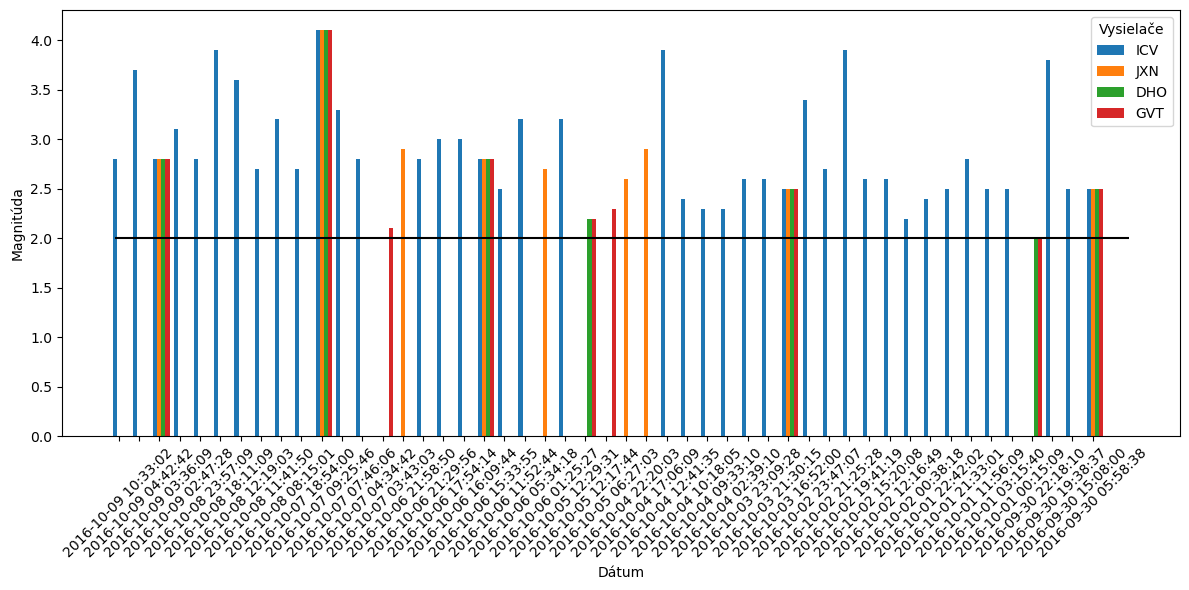

In [17]:
# vykreslenie najvacsich zemetraseni v danej hodine

print(len(df_eq["eqid"]))
print(len(df_eq["eqid"].unique()))

first_50_eq = df_eq[480:546]
unique_dates = first_50_eq.get("datetime").unique()
transmitters = first_50_eq.get("has_influence_on").unique()

x_positions = range(len(unique_dates))
bar_width = 0.2  

plt.figure(figsize=(12, 6))
for i, trans in enumerate(transmitters):
    magnitudes = []
    for date in unique_dates:
        value = first_50_eq.loc[(first_50_eq.get("datetime") == date) & (first_50_eq.get("has_influence_on") == trans), "magnitude"]
        magnitudes.append(value.iloc[0] if not value.empty else 0)
    
    plt.bar(
        [x + (i * bar_width) for x in x_positions], 
        magnitudes,
        bar_width,
        label=trans
    )

plt.hlines(2, 0, 50, color="black")
plt.xticks([x + bar_width for x in x_positions], unique_dates, rotation=45)
plt.xlabel("Dátum")
plt.ylabel("Magnitúda")
plt.legend(title="Vysielače")
plt.tight_layout()
plt.show()